In [1]:
%%capture

# Change some display properties
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))
import matplotlib.pyplot as plt
import numpy as np
import windspectra
import os.path
from matplotlib.lines import Line2D
%matplotlib inline

In [21]:
# Average the spectra over multiple locations
# given by locations in planefilelist
def avgSpectraPlanefiles(planefilelist, verbose=True):
    # set initial values
    iplane = 0
    all_ulongavgs = []
    lent = 0
    # Loop through and get spectra
    for planefile in planefilelist:
        if not os.path.isfile(datadir+'/'+planefile): continue
        dat       = np.loadtxt(datadir+'/'+planefile)
        t   = dat[:,0]
        z   = dat[:,6]
        u   = dat[:,7]
        v   = dat[:,8]
        w   = dat[:,9]
        if ((iplane != 0) and (lent != len(t))): continue
        if verbose: print("Loaded plane "+planefile)
        ulong, ulat = windspectra.convertUxytoLongLat(u,v)
        all_ulongavgs.append(np.mean(ulong))
        f, Suu      = windspectra.avgWindSpectra(t, ulong, avgbins)
        f, Svv      = windspectra.avgWindSpectra(t, ulat,  avgbins)
        f, Sww      = windspectra.avgWindSpectra(t, w,     avgbins)
        if iplane == 0:
            lent    = len(t)
            favg    = f
            Suu_avg  = Suu
            Svv_avg  = Svv
            Sww_avg  = Sww
        else:
            Suu_avg  = Suu_avg + Suu
            Svv_avg  = Svv_avg + Svv
            Sww_avg  = Sww_avg + Sww
        iplane = iplane+1
        zavg   = np.mean(z)
    # Average the spectra
    Suu_avg = Suu_avg/iplane
    Svv_avg = Svv_avg/iplane
    Sww_avg = Sww_avg/iplane
    if verbose: print("Averaged over %i planes"%iplane)
    return favg, Suu_avg, Svv_avg, Sww_avg, np.mean(all_ulongavgs), zavg

In [3]:
# Define some dicts to save stuff
Suu_avg={}
Svv_avg={}
Sww_avg={}
avgUlong={}
zavg={}
favg={}
Su_Kai={}
Sv_Kai={}
Sw_Kai={}

In [4]:
# Define data locations and variables
datadir  = '/ascldap/users/lcheung/nscratch/Torque2020/Runs/neutral/10ms/10ms_iter03/statsData/extractpoints/HHplane_plane0'
planeprefix = 'HHplane_'
planenum = 0
jvector  = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550] #[0, 100, 200, 300, 400, 500]
ivector  = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550] #[0, 100, 200, 300, 400, 500]

# Averaging bins
#avgbins  = [[15500,  16800], [16150, 17450]] 
#avgbins  = [[15500.5,  17500], [16500, 18500]] 
avgbins  = [[15500.5,  18100], [16800.5, 19400]] 

# Friction velocity.  Eventually this should be pulled from the ABL stats file
utau     = 0.3002

In [5]:
# Construct the list of planefiles and average
s='20'
planefiles=[]
for j in jvector:
    for i in ivector:
        planefiles.append(planeprefix+'%i_%i_%i.dat'%(planenum, j,i))
favg[s], Suu_avg[s], Svv_avg[s], Sww_avg[s], avgUlong[s], zavg[s] = avgSpectraPlanefiles(planefiles, verbose=True)

Loaded plane HHplane_0_0_0.dat
Loaded plane HHplane_0_0_50.dat
Loaded plane HHplane_0_0_100.dat
Loaded plane HHplane_0_0_150.dat
Loaded plane HHplane_0_0_200.dat
Loaded plane HHplane_0_0_250.dat
Loaded plane HHplane_0_0_300.dat
Loaded plane HHplane_0_0_350.dat
Loaded plane HHplane_0_0_400.dat
Loaded plane HHplane_0_0_450.dat
Loaded plane HHplane_0_0_500.dat
Loaded plane HHplane_0_0_550.dat
Loaded plane HHplane_0_50_0.dat
Loaded plane HHplane_0_50_50.dat
Loaded plane HHplane_0_50_100.dat
Loaded plane HHplane_0_50_150.dat
Loaded plane HHplane_0_50_200.dat
Loaded plane HHplane_0_50_250.dat
Loaded plane HHplane_0_50_300.dat
Loaded plane HHplane_0_50_350.dat
Loaded plane HHplane_0_50_400.dat
Loaded plane HHplane_0_50_450.dat
Loaded plane HHplane_0_50_500.dat
Loaded plane HHplane_0_50_550.dat
Loaded plane HHplane_0_100_0.dat
Loaded plane HHplane_0_100_50.dat
Loaded plane HHplane_0_100_100.dat
Loaded plane HHplane_0_100_150.dat
Loaded plane HHplane_0_100_200.dat
Loaded plane HHplane_0_100_250

In [25]:
# Get the equivalent Kaimal spectra
#avgUlong = np.mean(all_ulongavgs)
s='20'
print("Avg Ulong = %f zavg = %f"%(avgUlong[s], zavg[s]))
Su_Kai[s] = windspectra.getKaimal(favg[s], zavg[s], avgUlong[s])
Sv_Kai[s] = windspectra.getKaimal(favg[s], zavg[s], avgUlong[s], params=windspectra.vKaimalconst)
Sw_Kai[s] = windspectra.getKaimal(favg[s], zavg[s], avgUlong[s], params=windspectra.wKaimalconst)

fmax = 0.6*avgUlong[s]/(8*np.sqrt(2)*10)
print("fmax = %f"%fmax)
print("nmax = %f"%(fmax*zavg[s]/utau))

Avg Ulong = 9.983870 zavg = 20.000000
fmax = 0.052947
nmax = 3.527480


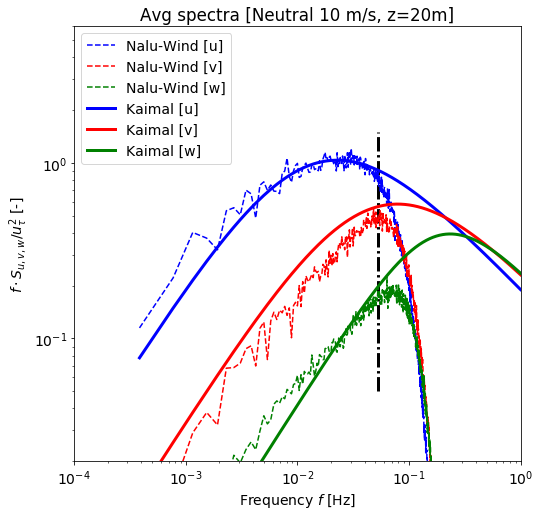

In [7]:
# Plot the longitudinal spectral
plt.figure(figsize=(8,8))
plt.rc('font', size=14)
plt.rc('xtick', labelsize=14)
# Plot the Nalu Wind spectra
s='20'
f=favg[s]
plt.loglog(f, f*Suu_avg[s]/utau**2, 'b--', label='Nalu-Wind [u]')
plt.loglog(f, f*Svv_avg[s]/utau**2, 'r--', label='Nalu-Wind [v]')
plt.loglog(f, f*Sww_avg[s]/utau**2, 'g--', label='Nalu-Wind [w]')

# Plot Kaimal
plt.loglog(f, Su_Kai[s],'b', lw=3, label='Kaimal [u]')
plt.loglog(f, Sv_Kai[s],'r', lw=3, label='Kaimal [v]')
plt.loglog(f, Sw_Kai[s],'g', lw=3, label='Kaimal [w]')

# Plot where the spectral cut-off is
plt.vlines(fmax, 5e-2, 1.5,lw=3, linestyle='-.')

# Formatting options
plt.ylim([2E-2, 6]);
plt.xlim([1E-4, 1]);
plt.xlabel('Frequency $f$ [Hz]')
plt.ylabel('$f\cdot S_{u,v,w}/u_{\\tau}^2$ [-]')
plt.title('Avg spectra [Neutral 10 m/s, z=%sm]'%s)
plt.legend(loc='upper left')

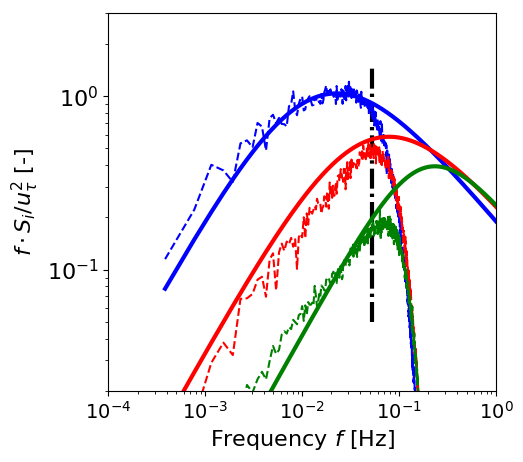

In [8]:
# --- Paper version ---
plt.figure(figsize=(5,5),dpi=100)
plt.rc('font', size=16)
plt.rc('xtick', labelsize=14)
# Plot the Nalu Wind spectra
s='20'
f=favg[s]
plt.loglog(f, f*Suu_avg[s]/utau**2, 'b--', label='Nalu-Wind [u]')
plt.loglog(f, f*Svv_avg[s]/utau**2, 'r--', label='Nalu-Wind [v]')
plt.loglog(f, f*Sww_avg[s]/utau**2, 'g--', label='Nalu-Wind [w]')

# Plot Kaimal
plt.loglog(f, Su_Kai[s],'b', lw=3, label='Kaimal [u]')
plt.loglog(f, Sv_Kai[s],'r', lw=3, label='Kaimal [v]')
plt.loglog(f, Sw_Kai[s],'g', lw=3, label='Kaimal [w]')

# Plot where the spectral cut-off is
plt.vlines(fmax, 5e-2, 1.5,lw=3, linestyle='-.')

# Formatting options
plt.ylim([2E-2, 3]);
plt.xlim([1E-4, 1]);
plt.xlabel('Frequency $f$ [Hz]')
plt.ylabel('$f\cdot S_{i}/u_{\\tau}^2$ [-]')
#plt.title('Avg spectra [Neutral 10 m/s, z=%sm]'%s)
#plt.legend(loc='upper left')

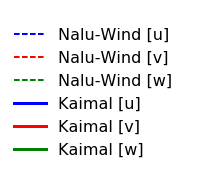

In [9]:
# --- just make a legend ---
legend_el = [Line2D([0],[0], linestyle='--', color='b', linewidth=2, label='Nalu-Wind [u]'),
             Line2D([0],[0], linestyle='--', color='r', linewidth=2, label='Nalu-Wind [v]'),
             Line2D([0],[0], linestyle='--', color='g', linewidth=2, label='Nalu-Wind [w]'),
             Line2D([0],[0], linestyle='-',  color='b', linewidth=3, label='Kaimal [u]'),
             Line2D([0],[0], linestyle='-',  color='r', linewidth=3, label='Kaimal [v]'),
             Line2D([0],[0], linestyle='-',  color='g', linewidth=3, label='Kaimal [w]'),
            ]
plt.figure(figsize=(3,1))
plt.legend(handles=legend_el, fontsize=16, frameon=False)
plt.axis('off')
plt.tight_layout()

In [19]:
# Define data locations and variables for z=40m
datadir  = '/ascldap/users/lcheung/nscratch/Torque2020/Runs/neutral/10ms/10ms_iter03/statsData/extractpoints/HHplane_plane1'
planeprefix = 'HHplane_'
planenum = 1
jvector  = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550] #[0, 100, 200, 300, 400, 500]
ivector  = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550] #[0, 100, 200, 300, 400, 500]

# Averaging bins
#avgbins  = [[15500,  16800], [16150, 17450]] 
#avgbins  = [[15500.5,  17500], [16500, 18500]] 
avgbins  = [[15500.5,  18100], [16800.5, 19400]] 

# Friction velocity.  Eventually this should be pulled from the ABL stats file
utau     = 0.3002

In [22]:
# Construct the list of planefiles and average
s='40'
planefiles=[]
for j in jvector:
    for i in ivector:
        planefiles.append(planeprefix+'%i_%i_%i.dat'%(planenum, j,i))
favg[s], Suu_avg[s], Svv_avg[s], Sww_avg[s], avgUlong[s], zavg[s] = avgSpectraPlanefiles(planefiles, verbose=True)

Loaded plane HHplane_1_50_0.dat
Loaded plane HHplane_1_50_50.dat
Loaded plane HHplane_1_50_100.dat
Loaded plane HHplane_1_50_150.dat
Loaded plane HHplane_1_50_200.dat
Loaded plane HHplane_1_50_250.dat
Loaded plane HHplane_1_50_300.dat
Loaded plane HHplane_1_50_350.dat
Loaded plane HHplane_1_50_400.dat
Loaded plane HHplane_1_50_450.dat
Loaded plane HHplane_1_50_500.dat
Loaded plane HHplane_1_50_550.dat
Loaded plane HHplane_1_100_0.dat
Loaded plane HHplane_1_100_50.dat
Loaded plane HHplane_1_100_100.dat
Loaded plane HHplane_1_100_150.dat
Loaded plane HHplane_1_100_200.dat
Loaded plane HHplane_1_100_250.dat
Loaded plane HHplane_1_100_300.dat
Loaded plane HHplane_1_100_350.dat
Loaded plane HHplane_1_100_400.dat
Loaded plane HHplane_1_100_450.dat
Loaded plane HHplane_1_100_500.dat
Loaded plane HHplane_1_100_550.dat
Loaded plane HHplane_1_150_0.dat
Loaded plane HHplane_1_150_50.dat
Loaded plane HHplane_1_150_100.dat
Loaded plane HHplane_1_150_150.dat
Loaded plane HHplane_1_150_200.dat
Loaded

In [24]:
# Get the equivalent Kaimal spectra
#avgUlong = np.mean(all_ulongavgs)
s='40'
print("Avg Ulong = %f zavg = %f"%(avgUlong[s], zavg[s]))
Su_Kai[s] = windspectra.getKaimal(favg[s], zavg[s], avgUlong[s])
Sv_Kai[s] = windspectra.getKaimal(favg[s], zavg[s], avgUlong[s], params=windspectra.vKaimalconst)
Sw_Kai[s] = windspectra.getKaimal(favg[s], zavg[s], avgUlong[s], params=windspectra.wKaimalconst)

fmax = 0.6*avgUlong[s]/(8*np.sqrt(2)*10)
print("fmax = %f"%fmax)
print("nmax = %f"%(fmax*zavg[s]/utau))

Avg Ulong = 10.534642 zavg = 40.000000
fmax = 0.055868
nmax = 7.444154


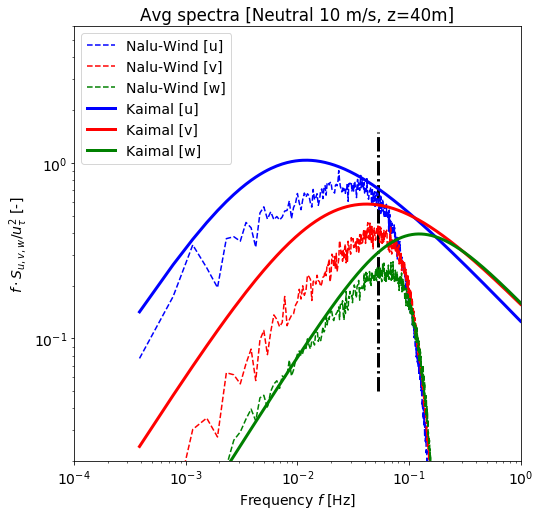

In [26]:
# Plot the longitudinal spectral
plt.figure(figsize=(8,8))
plt.rc('font', size=14)
plt.rc('xtick', labelsize=14)
# Plot the Nalu Wind spectra
s='40'
f=favg[s]
plt.loglog(f, f*Suu_avg[s]/utau**2, 'b--', label='Nalu-Wind [u]')
plt.loglog(f, f*Svv_avg[s]/utau**2, 'r--', label='Nalu-Wind [v]')
plt.loglog(f, f*Sww_avg[s]/utau**2, 'g--', label='Nalu-Wind [w]')

# Plot Kaimal
plt.loglog(f, Su_Kai[s],'b', lw=3, label='Kaimal [u]')
plt.loglog(f, Sv_Kai[s],'r', lw=3, label='Kaimal [v]')
plt.loglog(f, Sw_Kai[s],'g', lw=3, label='Kaimal [w]')

# Plot where the spectral cut-off is
plt.vlines(fmax, 5e-2, 1.5,lw=3, linestyle='-.')

# Formatting options
plt.ylim([2E-2, 6]);
plt.xlim([1E-4, 1]);
plt.xlabel('Frequency $f$ [Hz]')
plt.ylabel('$f\cdot S_{u,v,w}/u_{\\tau}^2$ [-]')
plt.title('Avg spectra [Neutral 10 m/s, z=%sm]'%s)
plt.legend(loc='upper left')

In [27]:
# Define data locations and variables for z=60m 
datadir  = '/ascldap/users/lcheung/nscratch/Torque2020/Runs/neutral/10ms/10ms_iter03/statsData/extractpoints/HHplane_plane2'
planeprefix = 'HHplane_'
planenum = 2
jvector  = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550] #[0, 100, 200, 300, 400, 500]
ivector  = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550] #[0, 100, 200, 300, 400, 500]

# Averaging bins
#avgbins  = [[15500,  16800], [16150, 17450]] 
#avgbins  = [[15500.5,  17500], [16500, 18500]] 
avgbins  = [[15500.5,  18100], [16800.5, 19400]] 

# Friction velocity.  Eventually this should be pulled from the ABL stats file
utau     = 0.3002

In [28]:
# Construct the list of planefiles and average
s='60'
planefiles=[]
for j in jvector:
    for i in ivector:
        planefiles.append(planeprefix+'%i_%i_%i.dat'%(planenum, j,i))
favg[s], Suu_avg[s], Svv_avg[s], Sww_avg[s], avgUlong[s], zavg[s] = avgSpectraPlanefiles(planefiles, verbose=True)

Loaded plane HHplane_2_50_0.dat
Loaded plane HHplane_2_50_50.dat
Loaded plane HHplane_2_50_100.dat
Loaded plane HHplane_2_50_150.dat
Loaded plane HHplane_2_50_200.dat
Loaded plane HHplane_2_50_250.dat
Loaded plane HHplane_2_50_300.dat
Loaded plane HHplane_2_50_350.dat
Loaded plane HHplane_2_50_400.dat
Loaded plane HHplane_2_50_450.dat
Loaded plane HHplane_2_50_500.dat
Loaded plane HHplane_2_50_550.dat
Loaded plane HHplane_2_100_0.dat
Loaded plane HHplane_2_100_50.dat
Loaded plane HHplane_2_100_100.dat
Loaded plane HHplane_2_100_150.dat
Loaded plane HHplane_2_100_200.dat
Loaded plane HHplane_2_100_250.dat
Loaded plane HHplane_2_100_300.dat
Loaded plane HHplane_2_100_350.dat
Loaded plane HHplane_2_100_400.dat
Loaded plane HHplane_2_100_450.dat
Loaded plane HHplane_2_100_500.dat
Loaded plane HHplane_2_100_550.dat
Loaded plane HHplane_2_150_0.dat
Loaded plane HHplane_2_150_50.dat
Loaded plane HHplane_2_150_100.dat
Loaded plane HHplane_2_150_150.dat
Loaded plane HHplane_2_150_200.dat
Loaded

In [29]:
# Get the equivalent Kaimal spectra
#avgUlong = np.mean(all_ulongavgs)
s='60'
print("Avg Ulong = %f zavg = %f"%(avgUlong[s], zavg[s]))
Su_Kai[s] = windspectra.getKaimal(favg[s], zavg[s], avgUlong[s])
Sv_Kai[s] = windspectra.getKaimal(favg[s], zavg[s], avgUlong[s], params=windspectra.vKaimalconst)
Sw_Kai[s] = windspectra.getKaimal(favg[s], zavg[s], avgUlong[s], params=windspectra.wKaimalconst)

fmax = 0.6*avgUlong[s]/(8*np.sqrt(2)*10)
print("fmax = %f"%fmax)
print("nmax = %f"%(fmax*zavg[s]/utau))

Avg Ulong = 10.847243 zavg = 60.000000
fmax = 0.057526
nmax = 11.497573


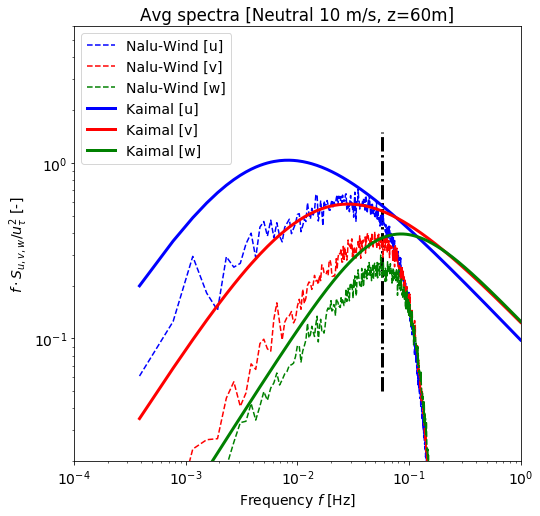

In [32]:
# Plot the longitudinal spectral
plt.figure(figsize=(8,8))
plt.rc('font', size=14)
plt.rc('xtick', labelsize=14)
# Plot the Nalu Wind spectra
s='60'
f=favg[s]
plt.loglog(f, f*Suu_avg[s]/utau**2, 'b--', label='Nalu-Wind [u]')
plt.loglog(f, f*Svv_avg[s]/utau**2, 'r--', label='Nalu-Wind [v]')
plt.loglog(f, f*Sww_avg[s]/utau**2, 'g--', label='Nalu-Wind [w]')

# Plot Kaimal
plt.loglog(f, Su_Kai[s],'b', lw=3, label='Kaimal [u]')
plt.loglog(f, Sv_Kai[s],'r', lw=3, label='Kaimal [v]')
plt.loglog(f, Sw_Kai[s],'g', lw=3, label='Kaimal [w]')

# Plot where the spectral cut-off is
plt.vlines(fmax, 5e-2, 1.5,lw=3, linestyle='-.')

# Formatting options
plt.ylim([2E-2, 6]);
plt.xlim([1E-4, 1]);
plt.xlabel('Frequency $f$ [Hz]')
plt.ylabel('$f\cdot S_{u,v,w}/u_{\\tau}^2$ [-]')
plt.title('Avg spectra [Neutral 10 m/s, z=%sm]'%s)
plt.legend(loc='upper left')

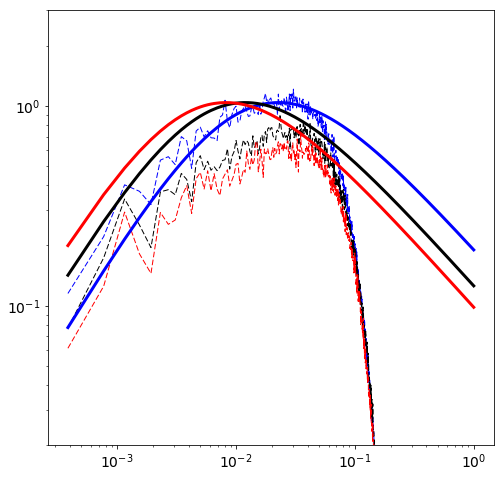

In [33]:
plt.figure(figsize=(8,8))
#Su_Kai20 = windspectra.getKaimal(favg, 20, 5.0)
#Su_Kai40 = windspectra.getKaimal(favg/3, 40, 5.2)
#plt.loglog(favg*20/5.00, favg*Suu_avg20/utau**2,'b--', lw=1, label='Kaimal [20]')
#plt.loglog(favg*40/5.28, favg*Suu_avg40/utau**2,'k--', lw=1, label='Kaimal [40]')
#plt.loglog(favg*20/5.00, Su_Kai20,'b', lw=3, label='Kaimal [20]')
#plt.loglog(favg*40/5.28, Su_Kai40,'k', lw=3, label='Kaimal [40]')

plt.loglog(favg['20'], favg['20']*Suu_avg['20']/utau**2,'b--', lw=1, label='Kaimal [20]')
plt.loglog(favg['40'], favg['40']*Suu_avg['40']/utau**2,'k--', lw=1, label='Kaimal [40]')
plt.loglog(favg['60'], favg['60']*Suu_avg['60']/utau**2,'r--', lw=1, label='Kaimal [40]')
plt.loglog(favg['20'], Su_Kai['20'],  'b',  lw=3, label='Kaimal [20]')
plt.loglog(favg['40'], Su_Kai['40'],  'k', lw=3, label='Kaimal [40]')
plt.loglog(favg['60'], Su_Kai['60'],  'r', lw=3, label='Kaimal [60]')

# Formatting options
plt.ylim([2E-2, 3]);